In [1]:
from typing import Callable, Any
from functools import partial

import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax
import jaxopt
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
from typing import Callable, List, Tuple
import random
import numpy as np
from typing import List, Dict, Tuple
import netket as nk
    
from dataset_generation import joint, uniform, RegressionDataset , generate_noisy_split_trainingdata
from torch.utils.data import DataLoader

# Ensure reproducibility
rng = jax.random.PRNGKey(0)
print('CUDA?', jax.devices(), jax.devices()[0].device_kind)

c:\TU Delft\YEAR 3\RP\bsc_students\bsc_students\RP-2024\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA? [CpuDevice(id=0)] cpu


In [2]:
# Test-configuration
dataset_size = 128
test_resolution = 512

# Train-configuration
num_posterior_mc = 1  # number of latents to sample from p(Z | X, Y)
batch_size = 128  # number of functions to sample from p(Z)
kl_penalty = 1e-4  # Magnitude of the KL-divergence in the loss
num_target_samples = 32
num_context_samples = 64

In [3]:
def joint(
    module: nn.Module, 
    data_sampler: Callable[[nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], tuple[jax.Array, jax.Array]],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    key_param, key_rng, key_data = jax.random.split(key, 3)
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)
    if return_params:
        return xs, ys, params
    return xs, ys

def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]
    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})
    return xs, ys

In [4]:
class Fourier_nr(nn.Module):
    """Generate random functions as the sum of randomized sine waves

    i.e. (simplified),
        z = scale * x - shift,
        y = a_0 + sum_(i=1...n) a_i cos(2pi * i * z - phi_i),
    where a_i are amplitudes and phi_i are phase shifts.

    See the Amplitude-Phase form,
     - https://en.wikipedia.org/wiki/Fourier_series
    """
    n: int = 3
    period: float = 1.0
    amplitude: jax.typing.ArrayLike = jnp.array([1.0, 0.5, 0.25])
    phase: jax.typing.ArrayLike = jnp.array([0.0, jnp.pi/4, jnp.pi/2])

    # def setup(self):
    #     # Ensure amplitude and phase are jax arrays
    #     self.amplitude = jnp.array(self.amplitude)
    #     self.phase = jnp.array(self.phase)

    @nn.compact
    def __call__(self, x: jax.typing.ArrayLike) -> jax.Array:
        # shift = self.param(
        #     'shift',
        #     nn.initializers.uniform(scale=jnp.pi),
        #     jnp.shape(x), x.dtype
        # )

        # x = x - shift

        # (heuristic) Monotonically scale amplitudes.
        amplitude = self.amplitude * jnp.arange(1, len(self.amplitude) + 1) / (self.n - 1)

        waves = jnp.cos(
            (2 * jnp.pi * jnp.arange(1, self.n) * x - self.phase) / self.period
        )

        return amplitude[0] / 2.0 + jnp.sum(amplitude[1:] * waves, axis=0)

In [5]:
def RMSE_means(model, params, x_context, y_context, x_target, y_target, rng, k):
    
    y_means, y_stds = model.apply(params, x_context, y_context, x_target,k=k, rngs={'default': rng}) 
    
    
    return jnp.sqrt(jnp.mean((y_means - y_target)**2))

In [6]:
# Define chromosome structure
Chromosome = Dict[str, np.ndarray]
# Dummy fitness calculation function (to be replaced with actual regressor model loss inversion)
def calculate_fitness(chromosome: Chromosome, key, model, params, num_evaluation_samples: int = 1) -> float:
    # Create a Fourier instance from the chromosome
    fourier_instance = Fourier_nr(
        n=chromosome['n'],
        period=chromosome['period'],
        amplitude=jnp.array(chromosome['amplitudes']),
        phase=jnp.array(chromosome['phases'])
    )
        # Calculate the loss using the provided evaluate_model function
    # losses = []
    # for _ in range(num_evaluation_samples):
    #     key, subkey = jax.random.split(key)
    #     data_sampler_real = partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
    #     x, y = data_sampler_real(subkey)
    #     x, y = x[..., None], y[..., None]
    #     X, x_test = jnp.split(x, indices_or_sections=(num_context_samples,))
    #     y, y_test = jnp.split(y, indices_or_sections=(num_context_samples,))
    data_sampler_real = partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
    x, y = jax.vmap(data_sampler_real)(jax.random.split(key, num_evaluation_samples)) 
    x, y = x[..., None], y[..., None]

    #lets split them into the context and target sets
    x_contexts, x_targets = jnp.split(x, indices_or_sections=(num_context_samples, ), axis=1)
    y_contexts, y_targets = jnp.split(y, indices_or_sections=(num_context_samples, ), axis=1)
    key, subkey = jax.random.split(key)
    ece_errors = nk.jax.vmap_chunked(partial(RMSE_means, model, params, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=128*100)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(subkey, num_evaluation_samples))

    #losses.append(loss)
    average_loss = jnp.mean(jnp.array(ece_errors))
    return 1 / (average_loss + 1e-8)

In [70]:
# Initialize population with random chromosomes
def initialize_population(pop_size: int, n_range: Tuple[int, int], period_range: Tuple[float, float], amplitude_range: Tuple[float, float], phase_range: Tuple[float, float]) -> List[Chromosome]:
    population = []
    for _ in range(pop_size):
        n = random.randint(n_range[0], n_range[1])
        period = random.uniform(period_range[0], period_range[1])
        amplitudes = np.random.uniform(amplitude_range[0], amplitude_range[1], size=(n,))
        phases = np.random.uniform(phase_range[0], phase_range[1], size=(n-1,))
        chromosome = {
            'n': n,
            'period': period,
            'amplitudes': amplitudes,
            'phases': phases
        }
        population.append(chromosome)
    return population

# Crossover between two parent chromosomes
def crossover(parent1: Chromosome, parent2: Chromosome) -> Chromosome:
    child = {}
    
    # Choose n and period from parents
    n1, n2 = parent1['n'], parent2['n']
    n = random.choice([n1, n2])
    period = random.uniform(parent1['period'], parent2['period'])

    # Interpolate amplitudes and phases
    amplitudes1 = np.copy(parent1['amplitudes'])
    amplitudes2 = np.copy(parent2['amplitudes'])
    phases1 = np.copy(parent1['phases'])
    phases2 = np.copy(parent2['phases'])
    if n1 < n2:
        amplitudes1 = np.pad(parent1['amplitudes'], (0, n2 - n1), mode='constant', constant_values=0)
        phases1 = np.pad(parent1['phases'], (0, n2 - n1), mode='constant', constant_values=0)
    else:
        amplitudes2 = np.pad(parent2['amplitudes'], (0, n1 - n2), mode='constant', constant_values=0)
        phases2 = np.pad(parent2['phases'], (0, n1 - n2), mode='constant', constant_values=0)
    
    amplitudes = np.array([random.choice([a, b]) for a, b in zip(amplitudes1, amplitudes2)])
    phases = np.array([random.choice([a, b]) for a, b in zip(phases1, phases2)])
    
    # Select correct number of amplitudes and phases for the child
    child['n'] = n
    child['period'] = period
    child['amplitudes'] = amplitudes[:n]
    child['phases'] = phases[:n-1]

    return child

# Mutation function to introduce variations
def mutate(chromosome: Chromosome, n_range: Tuple[int, int], period_range: Tuple[float, float], amplitude_range: Tuple[float, float], phase_range: Tuple[float, float], mutation_rate: float) -> Chromosome:
    if random.uniform(0, 1) < mutation_rate:
        new_n = int(np.round(np.random.normal(chromosome['n'], (n_range[1] - n_range[0])) / 8))
        # # Ensure the new n is within the range
        new_n = max(n_range[0], min(n_range[1], new_n))
        original_n = chromosome['n']
        chromosome['n'] = new_n
        
        if chromosome['n'] != original_n:
            if chromosome['n'] > original_n:
                # Increase the size of the arrays
                additional_amplitudes = np.random.uniform(amplitude_range[0], amplitude_range[1], size=(chromosome['n'] - original_n,))
                additional_phases = np.random.uniform(phase_range[0], phase_range[1], size=(chromosome['n'] - original_n,))
                chromosome['amplitudes'] = np.concatenate((chromosome['amplitudes'], additional_amplitudes))
                chromosome['phases'] = np.concatenate((chromosome['phases'], additional_phases))
            else:
                # Decrease the size of the arrays
                chromosome['amplitudes'] = chromosome['amplitudes'][:chromosome['n']]
                chromosome['phases'] = chromosome['phases'][:chromosome['n'] - 1]


    if random.uniform(0, 1) < mutation_rate:
        new_period = np.random.normal(chromosome['period'], (period_range[1] - period_range[0]) / 8)
        new_period = max(period_range[0], min(period_range[1], new_period))
        chromosome['period'] = new_period
    if random.uniform(0, 1) < mutation_rate:
        for idx, amplitude in enumerate(chromosome['amplitudes']):
            new_amplitude = np.random.normal(amplitude, (amplitude_range[1] - amplitude_range[0]) / 8)
            new_amplitude = max(amplitude_range[0], min(amplitude_range[1], amplitude))
            chromosome['amplitudes'][idx] = new_amplitude
        
        #chromosome['amplitudes'] = np.random.uniform(amplitude_range[0], amplitude_range[1], size=(chromosome['n'],))
    if random.uniform(0, 1) < mutation_rate:
        for idx, phase in enumerate(chromosome['phases']):
            new_phase = np.random.normal(phase, (phase_range[1] - phase_range[0]) / 8)
            new_phase = max(phase_range[0], min(phase_range[1], new_phase))
            chromosome['phases'][idx] = new_phase
        
        #chromosome['phases'] = np.random.uniform(phase_range[0], phase_range[1], size=(chromosome['n'] - 1,))
    return chromosome

# Evolutionary loop
def evolutionary_algorithm(pop_size: int, generations: int, n_range: Tuple[int, int], period_range: Tuple[float, float], amplitude_range: Tuple[float, float], phase_range: Tuple[float, float], mutation_rate: float, top_k: int, retain_rate, rng, model, params):
    population = initialize_population(pop_size, n_range, period_range, amplitude_range, phase_range)
    best_fitness_log = []
    
    for generation in range(generations):
        # Evaluate fitness
        #rng, key = jax.random.split(rng)
        fitness_scores = [calculate_fitness(individual, key, model, params, num_evaluation_samples = 1) for individual in population]
        
        # Log best fitness for this generation
        best_fitness_log.append(max(fitness_scores))
        print(f"Generation {generation}: Best fitness - {max(fitness_scores)}")
        #average fitness
        print(f"Generation {generation}: Average fitness - {jnp.mean(jnp.array(fitness_scores))}")

        # Select parents based on fitness
        #normalize fitness scores to 0, 1
        fitness_scores = np.array(fitness_scores)
        #fitness_scores = (fitness_scores - fitness_scores.min()) / (fitness_scores.max() - fitness_scores.min())
        sorted_indices = np.argsort(fitness_scores)[::-1]
        sorted_population = [population[i] for i in sorted_indices]
        sorted_fitness_scores = [fitness_scores[i] for i in sorted_indices]
        
        # Retain a certain percentage of the top performers
        num_retained = int(pop_size * retain_rate)
        retained_population = sorted_population[:num_retained]
        
        # Breed the rest
        num_breed = pop_size - num_retained
        parents = random.choices(sorted_population, weights=sorted_fitness_scores, k=num_breed)
        next_generation = [crossover(random.choice(parents), random.choice(parents)) for _ in range(num_breed)]
        
        # # Create next generation through crossover
        # next_generation = [crossover(random.choice(parents), random.choice(parents)) for _ in range(pop_size)]
        
        # Apply mutation
        next_generation = [mutate(individual, n_range, period_range, amplitude_range, phase_range, mutation_rate) for individual in next_generation]
        
        population = retained_population + next_generation
    
    # Evaluate fitness for the final population
    fitness_scores = [calculate_fitness(individual, key, model, params, num_evaluation_samples=1) for individual in population]
    
    # Get the top_k best individuals
    best_indices = np.argsort(fitness_scores)[-top_k:]
    best_individuals = [population[i] for i in best_indices]
    best_fitnesses = [fitness_scores[i] for i in best_indices]
    
    return best_individuals, best_fitness_log, best_fitnesses

In [9]:
def create_model(rng):
    embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
    embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
    embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

    projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))
    output_model = nn.Sequential([
        ResBlock(
            MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
        ),
        ResBlock(
            MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
        ),
        nn.Dense(2)
    ])
    # output_model = MLP([64, 64, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
    projection_outputs = NonLinearMVN(output_model)

    posterior_aggregator = MeanAggregator(projection_posterior)
    # posterior_aggregator = SequenceAggregator(projection_posterior)

    model = MixtureNeuralProcess(
        embedding_xs, embedding_ys, embedding_both, 
        posterior_aggregator, 
        projection_outputs
    )

    rng, data_init_rng = jax.random.split(rng)

    xs = jax.random.uniform(data_init_rng, (128,)) * 2 - 1

    rng, key = jax.random.split(rng)
    params = model.init({'params': key, 'default': key}, xs[:, None], xs[:, None], xs[:3, None])
    return model, params

Generation 0: Best fitness - 0.40107930461622043
Generation 0: Average fitness - 0.16594158072949394
Generation 1: Best fitness - 0.40107930461622043
Generation 1: Average fitness - 0.1993899343003304
Generation 2: Best fitness - 0.40107930461622043
Generation 2: Average fitness - 0.2548952222253262
Generation 3: Best fitness - 0.4492969603830489
Generation 3: Average fitness - 0.3244496101000103
Generation 4: Best fitness - 0.4492969603830489
Generation 4: Average fitness - 0.32178786782426577
Generation 5: Best fitness - 0.492012757264424
Generation 5: Average fitness - 0.3749509093515007
Generation 6: Best fitness - 0.492012757264424
Generation 6: Average fitness - 0.44723259939832016
Generation 7: Best fitness - 0.492012757264424
Generation 7: Average fitness - 0.39949158065593016
Generation 8: Best fitness - 0.492012757264424
Generation 8: Average fitness - 0.41436878679164374
Generation 9: Best fitness - 0.8040543955149501
Generation 9: Average fitness - 0.42451511608655335
Best 

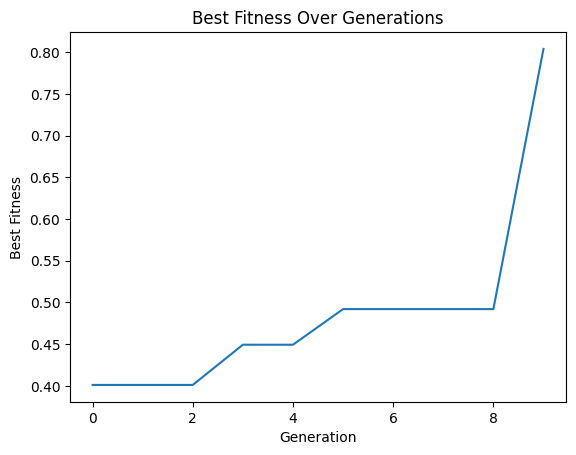

In [24]:
# Example usage
n_range = (2, 7)
period_range = (0.5, 2.0)
amplitude_range = (0.1, 10.0)
phase_range = (0.0, np.pi)
mutation_rate = 0.25
pop_size = 10
generations = 10
top_k = pop_size
chunk_size = 128*100
retain_rate = 0.5
key = rng = jax.random.key(0)

model, params = create_model(rng)
best_solutions, best_fitness_log = evolutionary_algorithm(pop_size, generations, n_range, period_range, amplitude_range, phase_range, mutation_rate, top_k, retain_rate, rng, model, params)

print("Best solutions:", best_solutions)
print("Best fitness log:", best_fitness_log)

# Plot the best fitness log
plt.plot(best_fitness_log)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations')
plt.show()

In [13]:
n_range = (2, 7)
period_range = (0.5, 2.0)
amplitude_range = (0.1, 10.0)
phase_range = (0.0, np.pi)
mutation_rate = 0.25
pop_size = 10
generations = 10
top_k = pop_size
chunk_size = 128*100
retain_rate = 0.5
key = rng = jax.random.key(0)
model, params = create_model(rng)
best_solutions, best_fitness_log, best_fitnesses = evolutionary_algorithm(pop_size, generations, n_range, period_range, amplitude_range, phase_range, mutation_rate, top_k, retain_rate, rng, model, params)
samplers = []
# convert best_fitnesses to probabilities proportional to fitnesses
total_fitness = sum(best_fitnesses)
ratios = [fitness / total_fitness for fitness in best_fitnesses]
ratios[-1] = 1 - sum(ratios[0: len(ratios) - 1])
print(ratios)
for chromosome in best_solutions:
    fourier_instance = Fourier_nr(
    n=chromosome['n'],
    period=chromosome['period'],
    amplitude=jnp.array(chromosome['amplitudes']),
    phase=jnp.array(chromosome['phases'])
)
        # Calculate the loss using the provided evaluate_model function
    # losses = []
    # for _ in range(num_evaluation_samples):
    #     key, subkey = jax.random.split(key)
    #     data_sampler_real = partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
    #     x, y = data_sampler_real(subkey)
    #     x, y = x[..., None], y[..., None]
    #     X, x_test = jnp.split(x, indices_or_sections=(num_context_samples,))
    #     y, y_test = jnp.split(y, indices_or_sections=(num_context_samples,))
    samplers.append(partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))))

rng, dataset_key = jax.random.split(rng)
chunk_size = 128*100
data_set_size = 128*1000
dataset = RegressionDataset(generate_noisy_split_trainingdata(samplers, ratios, data_set_size, chunk_size , dataset_key))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Generation 0: Best fitness - 0.20154190086356835
Generation 0: Average fitness - 0.13843379791943225
Generation 1: Best fitness - 0.21294135115845536
Generation 1: Average fitness - 0.158883401224998
Generation 2: Best fitness - 0.531994261484186
Generation 2: Average fitness - 0.23662430670053372
Generation 3: Best fitness - 0.5508615653973272
Generation 3: Average fitness - 0.2917314439543594
Generation 4: Best fitness - 0.5508615653973272
Generation 4: Average fitness - 0.31170895993172903
Generation 5: Best fitness - 0.5719680469017949
Generation 5: Average fitness - 0.3621735207488792
Generation 6: Best fitness - 0.5719680469017949
Generation 6: Average fitness - 0.3828555984004573
Generation 7: Best fitness - 0.5719680469017949
Generation 7: Average fitness - 0.5197462305749166
Generation 8: Best fitness - 1.0434289369888414
Generation 8: Average fitness - 0.5782204576138048
Generation 9: Best fitness - 1.0434289369888414
Generation 9: Average fitness - 0.5542151480108605
[Array(

In [72]:
class Fourier_range(nn.Module):
    n: int
    period_range: Tuple[float, float]
    amplitude_range: Tuple[float, float]
    phase_range: Tuple[float, float]

    def setup(self):
        
        self.period = self.param(
            'period', 
            nn.initializers.uniform(scale=self.period_range[1] - self.period_range[0]), 
            ()
        ) + self.period_range[0]

        self.amplitude = self.param(
            'amplitude', 
            nn.initializers.uniform(scale=self.amplitude_range[1] - self.amplitude_range[0]), 
            (self.n,)
        ) + self.amplitude_range[0]
        
        self.phase = self.param(
            'phase', 
            nn.initializers.uniform(scale=self.phase_range[1] - self.phase_range[0]), 
            (self.n - 1,)
        ) + self.phase_range[0]


    @nn.compact
    def __call__(self, x: jax.typing.ArrayLike) -> jax.Array:
        shift = self.param(
            'shift',
            nn.initializers.uniform(scale=jnp.pi),
            jnp.shape(x), x.dtype
        )
        x = x - shift
        amplitude = self.amplitude * jnp.arange(1, len(self.amplitude) + 1) / (self.n - 1)
        waves = jnp.cos(
            (2 * jnp.pi * jnp.arange(1, self.n) * x - self.phase) / self.period
        )

        return amplitude[0] / 2.0 + jnp.sum(amplitude[1:] * waves, axis=0)

In [14]:
period_range=[0.5, 2.0]
amplitude_range=[1, 10]
phase_range=[0.0, jnp.pi]
n_range = [2, 7]

fouriers = [Fourier_range(n=i, period_range=period_range, amplitude_range=amplitude_range, phase_range=phase_range) for i in range(n_range[0], n_range[1] + 1)]
samplers = [partial(joint, fourier, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))) for fourier in fouriers]
#equal ratios
ratios = [1.0 / (len(fouriers)) for _ in fouriers[:len(fouriers) - 1]]
ratios = ratios + [1.0 - sum(ratios)]

NameError: name 'Fourier_range' is not defined

In [74]:
rng, dataset_key = jax.random.split(rng)
chunk_size = 128*100
data_set_size = 128*1000
dataset = RegressionDataset(generate_noisy_split_trainingdata(samplers, ratios, data_set_size, chunk_size , dataset_key))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

TypeError: expand_dims requires ndarray or scalar arguments, got <class 'tuple'> at position 0.

In [71]:
samplers = []
ratios = []
# convert best_fitnesses to probabilities proportional to fitnesses
total_fitness = sum(best_fitnesses)
for fitness in best_fitnesses:
    ratio = fitness / total_fitness
    ratios.append(ratio)
    print(ratio)
#ratios = [fitness / total_fitness for fitness in best_fitnesses]
ratios[-1] = 1 - sum(ratios[0: len(ratios) - 1])
print(ratios)
for chromosome in best_solutions:
    fourier_instance = Fourier_nr(
    n=chromosome['n'],
    period=chromosome['period'],
    amplitude=jnp.array(chromosome['amplitudes']),
    phase=jnp.array(chromosome['phases'])
)
        # Calculate the loss using the provided evaluate_model function
    # losses = []
    # for _ in range(num_evaluation_samples):
    #     key, subkey = jax.random.split(key)
    #     data_sampler_real = partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
    #     x, y = data_sampler_real(subkey)
    #     x, y = x[..., None], y[..., None]
    #     X, x_test = jnp.split(x, indices_or_sections=(num_context_samples,))
    #     y, y_test = jnp.split(y, indices_or_sections=(num_context_samples,))
    samplers.append(partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))))

rng, dataset_key = jax.random.split(rng)
chunk_size = 128*100
data_set_size = 128*1000
dataset = RegressionDataset(generate_noisy_split_trainingdata(samplers, ratios, data_set_size, chunk_size , dataset_key))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

0.023885542259671853
0.02391632720319043
0.11563660703937471
0.1156525412418084
0.11745206947582024
0.11812127251174356
0.1203550488488433
0.12058376993842244
0.12219841074056248
0.12219841074056248
[Array(0.02388554, dtype=float64), Array(0.02391633, dtype=float64), Array(0.11563661, dtype=float64), Array(0.11565254, dtype=float64), Array(0.11745207, dtype=float64), Array(0.11812127, dtype=float64), Array(0.12035505, dtype=float64), Array(0.12058377, dtype=float64), Array(0.12219841, dtype=float64), Array(0.12219841, dtype=float64)]


TypeError: expand_dims requires ndarray or scalar arguments, got <class 'tuple'> at position 0.

In [15]:
def create_evol_dataset(best_solutions, best_fitnesses, dataset_size, rng):
    samplers = []
    # convert best_fitnesses to probabilities proportional to fitnesses
    total_fitness = sum(best_fitnesses)
    ratios = [fitness / total_fitness for fitness in best_fitnesses]
    ratios[-1] = 1 - sum(ratios[0: len(ratios) - 1])

    for chromosome in best_solutions:
        fourier_instance = Fourier_nr(
        n=chromosome['n'],
        period=chromosome['period'],
        amplitude=jnp.array(chromosome['amplitudes']),
        phase=jnp.array(chromosome['phases'])
    )
        samplers.append(partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))))

    rng, dataset_key = jax.random.split(rng)
    chunk_size = 128*100
    dataset = RegressionDataset(generate_noisy_split_trainingdata(samplers, ratios, dataset_size, chunk_size , dataset_key))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader

In [16]:
print(len(best_solutions))
print(len(best_fitnesses))

10
10


In [46]:
# Example usage
n_range = (3, 6)
period_range = (0.05, 2.0)
amplitude_range = (0.1, 10.0)
phase_range = (0.0, np.pi)
mutation_rate = 0.25
pop_size = 10
generations = 5
top_k = pop_size
chunk_size = 128*100
retain_rate = 0.5
key = rng = jax.random.key(0)

model, params = create_model(rng)
best_solutions, best_fitness_log, best_fitnesses = evolutionary_algorithm(pop_size, generations, n_range, period_range, amplitude_range, phase_range, mutation_rate, top_k, retain_rate, rng, model, params)


Generation 0: Best fitness - 0.2699177731521122
Generation 0: Average fitness - 0.15261645962129197
Generation 1: Best fitness - 0.2699177731521122
Generation 1: Average fitness - 0.18162455233947988


KeyboardInterrupt: 

In [17]:
dataset = create_evol_dataset(best_solutions, best_fitnesses, 128 * 1000, rng)
dataset_length = len(dataset)

# Get the shape of a single sample
#sample_shape = dataset[0][0].shape if isinstance(dataset[0], tuple) else dataset[0].shape

print(f"Dataset length: {dataset_length}")
#print(f"Shape of a single sample: {sample_shape}")

Dataset length: 999


In [18]:
def cross_entropy_error(model, params, x_context, y_context, x_target, y_target , rng , k):
    y_means, y_stds = model.apply(params, x_context, y_context, x_target,k=k, rngs={'default': rng})


    # Lets compute the log likelihood of the target points given the means and stds

    # Ensure y_means and y_stds are squeezed correctly
    y_means = jnp.squeeze(y_means, axis=-1) if k > 1 else jnp.squeeze(y_means)
    y_stds = jnp.squeeze(y_stds, axis=-1) if k > 1 else jnp.squeeze(y_stds)
    full_y = jnp.squeeze(y_target, axis=-1) if k > 1 else jnp.squeeze(y_target) 

    log_pdf = logpdf(full_y, y_means,y_stds) 
   


    return -jnp.mean(log_pdf)



def RMSE_means(model, params, x_context, y_context, x_target, y_target, rng, k):
    
    y_means, y_stds = model.apply(params, x_context, y_context, x_target,k=k, rngs={'default': rng}) 
    
    
    return jnp.sqrt(jnp.mean((y_means - y_target)**2))

In [19]:
def posterior_loss(
    params: flax.typing.VariableDict,
    batch,
    key: flax.typing.PRNGKey,
):
    key_data, key_model = jax.random.split(key)
    


    X = batch[0]
    y = batch[1]
    x_test = batch[2]
    y_test = batch[3]
    # Compute ELBO over batch of datasets
    elbos = jax.vmap(
    partial(
            model.apply,
            params,  
            beta=kl_penalty,
            k=num_posterior_mc,
            method=model.elbo
    ) 
    )(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, X.shape[0])}
    )
    
    return -elbos.mean()

@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState,
    current_batch,
    random_key: flax.typing.PRNGKey,
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    
    # value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, current_batch, random_key )
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    
    return theta, opt_state, value


def body_batch(carry, batch):
    params, opt_state, key = carry
    key_carry, key_step = jax.random.split(key)
    # Unpack the batch
    X_full, y_full = batch

    # Shuffle the data while preserving (X, y) pairs
    num_samples = X_full.shape[1]
    indices = jax.random.permutation(key_step, num_samples)
    X_full_shuffled = jnp.take(X_full, indices, axis=1)
    y_full_shuffled = jnp.take(y_full, indices, axis=1)

    # Split the shuffled data into context and test sets
    X, x_test = jnp.split(X_full_shuffled, indices_or_sections=(num_context_samples,), axis=1)
    y, y_test = jnp.split(y_full_shuffled, indices_or_sections=(num_context_samples,), axis=1)

    params, opt_state, value = step(params, opt_state, (X,y, x_test,y_test ), key_step )

    return (params, opt_state, key_carry ), value

@jax.jit
def scan_train(params, opt_state, key,  batches):
    
    last, out = jax.lax.scan(body_batch, (params, opt_state, key ), batches)

    params, opt_state, _ = last
    
    return params, opt_state, out

In [29]:
class Fourier_range(nn.Module):
    n: int
    period_range: Tuple[float, float]
    amplitude_range: Tuple[float, float]
    phase_range: Tuple[float, float]

    def setup(self):
        
        self.period = self.param(
            'period', 
            nn.initializers.uniform(scale=self.period_range[1] - self.period_range[0]), 
            ()
        ) + self.period_range[0]

        self.amplitude = self.param(
            'amplitude', 
            nn.initializers.uniform(scale=self.amplitude_range[1] - self.amplitude_range[0]), 
            (self.n,)
        ) + self.amplitude_range[0]
        
        self.phase = self.param(
            'phase', 
            nn.initializers.uniform(scale=self.phase_range[1] - self.phase_range[0]), 
            (self.n - 1,)
        ) + self.phase_range[0]


    @nn.compact
    def __call__(self, x: jax.typing.ArrayLike) -> jax.Array:
        shift = self.param(
            'shift',
            nn.initializers.uniform(scale=jnp.pi),
            jnp.shape(x), x.dtype
        )
        x = x - shift
        amplitude = self.amplitude * jnp.arange(1, len(self.amplitude) + 1) / (self.n - 1)
        waves = jnp.cos(
            (2 * jnp.pi * jnp.arange(1, self.n) * x - self.phase) / self.period
        )

        return amplitude[0] / 2.0 + jnp.sum(amplitude[1:] * waves, axis=0)

In [53]:
period_range=[0.05, 2.0]
amplitude_range=[0.1, 10.0]
phase_range=[0.0, jnp.pi]
n_range = [3, 6]

fouriers = [Fourier_range(n=i, period_range=period_range, amplitude_range=amplitude_range, phase_range=phase_range) for i in range(n_range[0], n_range[1] + 1)]
samplers_def = [partial(joint, fourier, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))) for fourier in fouriers]
#equal ratios
ratios_def = [1.0 / (len(fouriers)) for _ in fouriers[:len(fouriers)]]
#ratios = ratios + [1.0 - sum(ratios)]
print(fouriers)
# fourier_instance_range_2 = Fourier_range(
#     n=2,
#     period_range=[0.5, 2.0],
#     amplitude_range=[1, 10],
#     phase_range=[0.0, jnp.pi]
# )

[Fourier_range(
    # attributes
    n = 3
    period_range = [0.05, 2.0]
    amplitude_range = [0.1, 10.0]
    phase_range = [0.0, 3.141592653589793]
), Fourier_range(
    # attributes
    n = 4
    period_range = [0.05, 2.0]
    amplitude_range = [0.1, 10.0]
    phase_range = [0.0, 3.141592653589793]
), Fourier_range(
    # attributes
    n = 5
    period_range = [0.05, 2.0]
    amplitude_range = [0.1, 10.0]
    phase_range = [0.0, 3.141592653589793]
), Fourier_range(
    # attributes
    n = 6
    period_range = [0.05, 2.0]
    amplitude_range = [0.1, 10.0]
    phase_range = [0.0, 3.141592653589793]
)]


In [54]:
len(samplers_def)

4

In [60]:
def create_evol_dataset(best_solutions, best_fitnesses, dataset_size, evol_rate, rng):
    samplers = []
    # convert best_fitnesses to probabilities proportional to fitnesses
    total_fitness = sum(best_fitnesses)
    ratios = [(fitness / total_fitness) * evol_rate for fitness in best_fitnesses]
    

    for chromosome in best_solutions:
        fourier_instance = Fourier_nr(
        n=chromosome['n'],
        period=chromosome['period'],
        amplitude=jnp.array(chromosome['amplitudes']),
        phase=jnp.array(chromosome['phases'])
    )
        samplers.append(partial(joint, fourier_instance, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))))
    samplers += samplers_def
    ratios_def = [(1 - evol_rate) / (len(samplers_def)) for _ in samplers_def[:len(samplers_def)]]
    ratios += ratios_def
    ratios[-1] = 1 - sum(ratios[0: len(ratios) - 1])
    rng, dataset_key = jax.random.split(rng)
    chunk_size = 64*100
    dataset = RegressionDataset(generate_noisy_split_trainingdata(samplers, ratios, dataset_size, chunk_size , dataset_key))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader

In [66]:
def recreate_dataset(rng, model, params):
    best_solutions, best_fitness_log, best_fitnesses = evolutionary_algorithm(
        pop_size, generations, n_range, period_range, amplitude_range, phase_range,
        mutation_rate, top_k, retain_rate, rng, model, params
    )
    dataloader = create_evol_dataset(best_solutions, best_fitnesses, 10000, 0.3, rng)
    return dataloader

In [72]:
from tqdm import tqdm

save_path = "./evo_deneme5/"
model_name = "base_0_1_"
os.makedirs(save_path, exist_ok=True)
eval_intervals = 256
eval_dataset_size = 1000
evolution_interval = 2048

# Example usage
n_range = (3, 6)
period_range = (0.05, 2.0)
amplitude_range = (0.1, 10.0)
phase_range = (0.0, np.pi)
mutation_rate = 0.5
pop_size = 200
generations = 20
top_k = 50
retain_rate = 0.35
batch_size = 64
key = rng = jax.random.key(0)


model, params = create_model(key)
optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params

training_steps = 0
losses = []
best = float('inf')
best_params = None
eval_params = {"eval_point_model_params": []}
in_task_errors = {'ece': [], 'rmse': []}
out_task_errors = []
total_training_samples = 10000

def perform_evaluation(params_new, eval_epoch_key):
    eval_epoch_key, eval_inkey_data, eval_outkey_data, eval_model_key = jax.random.split(eval_epoch_key, 4)
    intask_x_eval, intask_y_eval = generate_noisy_split_trainingdata(samplers, ratios, eval_dataset_size, chunk_size, eval_inkey_data)
    intask_x_eval, intask_y_eval = intask_x_eval[..., None], intask_y_eval[..., None]

    x_contexts, x_targets = jnp.split(intask_x_eval, indices_or_sections=(num_context_samples,), axis=1)
    y_contexts, y_targets = jnp.split(intask_y_eval, indices_or_sections=(num_context_samples,), axis=1)

    ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0, 0, 0, 0, 0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
    rmse_errors = nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0, 0, 0, 0, 0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))

    in_task_errors['ece'].append((ece_errors.mean(), ece_errors.std() / np.sqrt(ece_errors.shape[0])))
    in_task_errors['rmse'].append((rmse_errors.mean(), rmse_errors.std() / np.sqrt(rmse_errors.shape[0])))
    eval_params["eval_point_model_params"].append(params_new)

pbar = tqdm(total=total_training_samples, desc='Training Progress')
train_till_eval = 0
while training_steps < total_training_samples:
    rng, key = jax.random.split(rng)
    _, eval_epoch_key = jax.random.split(rng)
    dataloader = recreate_dataset(rng, model, params)
    for batch in dataloader:
        if training_steps >= total_training_samples:
            break
    
        batcha = jnp.asarray(jax.tree_util.tree_map(lambda tensor: tensor.numpy(), [batch]))

        if (train_till_eval >= eval_intervals) and (training_steps != 0):
            perform_evaluation(params, eval_epoch_key)
            train_till_eval %= eval_intervals
        
        params, opt_state, loss_arr = scan_train(params, opt_state, key, batcha)
        training_steps += len(batch[0])
        train_till_eval += len(batch[0])
        losses.extend(loss_arr)

        if loss_arr.min() < best:
            best = loss_arr.min()
            best_params = params

        if jnp.isnan(loss_arr).any():
            break

        pbar.update(len(batch[0]))

        pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')
        if (training_steps % evolution_interval == 0) and (training_steps != 0):
            print("girdi: ", len(losses))
            break

    save_model_params(best_params, save_path, model_name)
    with open(os.path.join(save_path, model_name + '_eval_point_params.pkl'), 'wb') as f:
        pickle.dump(eval_params, f)
    with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'wb') as f:
        pickle.dump({"training_loss": losses, "training_intask_errors": in_task_errors, "training_outtask_errors": out_task_errors}, f)

pbar.close()


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Generation 0: Best fitness - 0.2296295941258831
Generation 0: Average fitness - 0.14322877454164848
Generation 1: Best fitness - 0.45460795404174825
Generation 1: Average fitness - 0.16635307618579293
Generation 2: Best fitness - 0.45460795404174825
Generation 2: Average fitness - 0.20267195997134305
Generation 3: Best fitness - 0.7248176214331398
Generation 3: Average fitness - 0.28968815921421287
Generation 4: Best fitness - 0.8192268862349763
Generation 4: Average fitness - 0.4075817769047191
Generation 5: Best fitness - 0.8192268862349763
Generation 5: Average fitness - 0.48755774296477117
Generation 6: Best fitness - 0.8192268862349763
Generation 6: Average fitness - 0.5245962308079959
Generation 7: Best fitness - 0.8192268862349763
Generation 7: Average fitness - 0.5698917926117482
Generation 8: Best fitness - 0.8192268862349763
Generation 8: Average fitness - 0.6157410373428742
Generation 9: Best fitness - 0.8192268862349763
Generation 9: Average fitness - 0.5967175261530271
Gen

KeyboardInterrupt: 

In [33]:
from model_utils import save_model_params, load_model_params
import pickle
import os
import netket as nk
from jax.scipy.stats.norm import logpdf
save_path="./noise_0_5_runs/"
model_name="baseddd_0_1_"
os.makedirs(save_path, exist_ok=True)
eval_intervals = 250
training_step_number = 5000
eval_dataset_size = 100
n_range = (2, 5)
period_range = (0.5, 4.0)
amplitude_range = (0.5, 10.0)
phase_range = (0.0, np.pi)
mutation_rate = 0.25
pop_size = 50
generations = 5
top_k = pop_size
chunk_size = 64*100
retain_rate = 0.5

model , params = create_model(key)
optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
in_task_errors = {'ece':[], 'rmse':[], 'std_residuals':[], "ece_noise" : [], "rmse_noise": []} # We will log the in task errors for the model
out_task_errors = {'ece':[], 'rmse':[], 'std_residuals':[], "ece_noise": [], "rmse_noise": []} # We will log the out of task errors for the model
eval_params = {"eval_point_model_params": []}
training_steps = 0



for i in (pbar := tqdm.trange(10, desc='Optimizing params. ')):

    rng, key = jax.random.split(rng)
    batches = recreate_dataset(rng, model, params)
    
    batches_until_eval = eval_intervals - (training_steps % eval_intervals)
    batches_until_end = training_step_number - training_steps
    if batches_until_end < len(batches):
        batches = batches[:batches_until_end]

    if batches_until_eval < len(batches):
        trained_steps_within_eval = 0
        batch_slice_pre_eval = eval_intervals - (training_steps % eval_intervals)
        batch_slice = batch_slice_pre_eval
        loss_array_eval = []
        params_new = params

        for i in range(0, 1 + ((len(batches) - batch_slice_pre_eval) // eval_intervals)):
            params_new, opt_state, loss_arr = scan_train(params_new, opt_state, key, batches[trained_steps_within_eval:(trained_steps_within_eval + batch_slice)])
            loss_array_eval.extend(loss_arr)
            trained_steps_within_eval += batch_slice
            batch_slice = eval_intervals
            eval_epoch_key, eval_inkey_data, eval_outkey_data, eval_model_key = jax.random.split(eval_epoch_key, 4)
            intask_x_eval, intask_y_eval = generate_noisy_split_trainingdata(samplers, ratios, eval_dataset_size, chunk_size , eval_inkey_data)
            #intask_x_eval, intask_y_eval = jax.vmap(sampler_clean)(jax.random.split(eval_inkey_data, eval_dataset_size)) 
            intask_x_eval, intask_y_eval = intask_x_eval[..., None], intask_y_eval[..., None]

            #lets split them into the context and target sets
            x_contexts, x_targets = jnp.split(intask_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
            y_contexts, y_targets = jnp.split(intask_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

            ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
            rmse_errors= nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, eval_dataset_size))
            
            # intasknoise_x_eval, intasknoise_y_eval = jax.vmap(sampler_noise)(jax.random.split(eval_inkey_data, eval_dataset_size))
            # intasknoise_x_eval, intasknoise_y_eval = intasknoise_x_eval[..., None], intasknoise_y_eval[..., None]

            # #lets split them into the context and target sets
            # x_contextsnoise, x_targetsnoise = jnp.split(intasknoise_x_eval, indices_or_sections=(num_context_samples, ), axis=1)
            # y_contextsnoise, y_targetsnoise = jnp.split(intasknoise_y_eval, indices_or_sections=(num_context_samples, ), axis=1)

            # ece_errors_noise = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contextsnoise, y_contextsnoise, x_targetsnoise, y_targetsnoise, jax.random.split(eval_model_key, eval_dataset_size))
            # rmse_errors_noise = nk.jax.vmap_chunked(partial(RMSE_means, model, params_new, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contextsnoise, y_contextsnoise, x_targetsnoise, y_targetsnoise, jax.random.split(eval_model_key, eval_dataset_size))
            #print("ece_errors_noise intask", ece_errors_noise.mean(), ece_errors_noise.std())
            # in_task_errors['ece_noise'].append((ece_errors_noise.mean(), ece_errors_noise.std()))
            # in_task_errors['rmse_noise'].append((rmse_errors_noise.mean(), rmse_errors_noise.std()))
            in_task_errors['ece'].append((ece_errors.mean(), ece_errors.std()))
            in_task_errors['rmse'].append((rmse_errors.mean(), rmse_errors.std()))

        if len(batches) - trained_steps_within_eval > 0:
            params_new, opt_state, loss_arr = scan_train(params_new, opt_state, key, batches[trained_steps_within_eval:])
            loss_array_eval.extend(loss_arr)

        loss_arr = jnp.asarray(loss_array_eval)
    else:
        params_new, opt_state, loss_arr = scan_train(params, opt_state, key, batches)
    
    training_steps += len(batches)
    losses.extend(loss_arr)

    if loss_arr.min() < best:
        best = loss_arr.min()
        best_params = params_new

    if jnp.isnan(loss_arr).any():
        break
    else:
        params = params_new

    pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

    if training_steps >= training_step_number:
        break
    
    save_model_params(best_params, save_path, model_name)
    with open(os.path.join(save_path, model_name + '_eval_point_params.pkl'), 'wb') as f:
        pickle.dump(eval_params, f)
    with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'wb') as f:
        pickle.dump({"training_loss": losses, "training_intask_errors": in_task_errors, "training_outtask_errors": out_task_errors}, f)


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

Generation 0: Best fitness - 0.5764832184022968
Generation 0: Average fitness - 0.1712938336788055
Generation 1: Best fitness - 0.9394888623560697
Generation 1: Average fitness - 0.24519451456489472
Generation 2: Best fitness - 1.1631575577126732
Generation 2: Average fitness - 0.44061800336057827
Generation 3: Best fitness - 1.2304457153803738
Generation 3: Average fitness - 0.5876984970293689
Generation 4: Best fitness - 1.2304457153803738
Generation 4: Average fitness - 0.708247155921129


Optimizing params. Loss: 0.2338:  10%|█         | 1/10 [06:11<55:46, 371.86s/it]

Generation 0: Best fitness - 0.5112863099440814
Generation 0: Average fitness - 0.13770437832763402
Generation 1: Best fitness - 0.5112863099440814
Generation 1: Average fitness - 0.15948774405023924
Generation 2: Best fitness - 0.5839035639776011
Generation 2: Average fitness - 0.20012479858722076
Generation 3: Best fitness - 0.5839035639776011
Generation 3: Average fitness - 0.23388749191678124
Generation 4: Best fitness - 0.7457610797968198
Generation 4: Average fitness - 0.29293917408022924


Optimizing params. Loss: 1.4115:  20%|██        | 2/10 [11:45<46:36, 349.61s/it]

Generation 0: Best fitness - 0.8675479178356527
Generation 0: Average fitness - 0.17711526317032522
Generation 1: Best fitness - 0.8675479178356527
Generation 1: Average fitness - 0.29284466601829706
Generation 2: Best fitness - 0.8675479178356527
Generation 2: Average fitness - 0.41354714919285396
Generation 3: Best fitness - 0.8675479178356527
Generation 3: Average fitness - 0.5777005859327767
Generation 4: Best fitness - 0.8987489186923492
Generation 4: Average fitness - 0.7281419759611316


Optimizing params. Loss: 0.1493:  30%|███       | 3/10 [17:18<39:53, 341.89s/it]

Generation 0: Best fitness - 1.135655953837733
Generation 0: Average fitness - 0.2173159278491373
Generation 1: Best fitness - 1.521728295832583
Generation 1: Average fitness - 0.3560795111402979
Generation 2: Best fitness - 1.8425553349718717
Generation 2: Average fitness - 0.5745442719668746
Generation 3: Best fitness - 1.8425553349718717
Generation 3: Average fitness - 0.6999950339115616
Generation 4: Best fitness - 1.8425553349718717
Generation 4: Average fitness - 0.8510257273939966


Optimizing params. Loss: 0.0362:  40%|████      | 4/10 [20:56<29:17, 292.85s/it]

Generation 0: Best fitness - 0.41346818291108356
Generation 0: Average fitness - 0.15145014476193688
Generation 1: Best fitness - 1.2860898142860244
Generation 1: Average fitness - 0.20339383774684502
Generation 2: Best fitness - 1.2860898142860244
Generation 2: Average fitness - 0.32551150464317574
Generation 3: Best fitness - 1.2860898142860244
Generation 3: Average fitness - 0.4769830019742034
Generation 4: Best fitness - 1.2926514149524595
Generation 4: Average fitness - 0.6429777580906406


Optimizing params. Loss: 0.0288:  50%|█████     | 5/10 [24:36<22:12, 266.59s/it]

Generation 0: Best fitness - 0.9035824371588862
Generation 0: Average fitness - 0.16072727392150463
Generation 1: Best fitness - 1.0152265375964917
Generation 1: Average fitness - 0.27942933805306075
Generation 2: Best fitness - 1.1422079546899286
Generation 2: Average fitness - 0.4859122771670809
Generation 3: Best fitness - 1.8728716537819983
Generation 3: Average fitness - 0.8191253772183964
Generation 4: Best fitness - 1.8728716537819983
Generation 4: Average fitness - 0.902854769563596


Optimizing params. Loss: -0.9428:  60%|██████    | 6/10 [28:15<16:41, 250.46s/it]

Generation 0: Best fitness - 0.640970697419304
Generation 0: Average fitness - 0.15113319627028202
Generation 1: Best fitness - 0.7851565734565648
Generation 1: Average fitness - 0.2221008472434682
Generation 2: Best fitness - 0.995802021921458
Generation 2: Average fitness - 0.35947028826178845
Generation 3: Best fitness - 2.30727682169226
Generation 3: Average fitness - 0.5989177828187564
Generation 4: Best fitness - 4.893947252177533
Generation 4: Average fitness - 0.9570150288716077


Optimizing params. Loss: -0.6153:  70%|███████   | 7/10 [32:43<12:48, 256.19s/it]

Generation 0: Best fitness - 0.5662997914911471
Generation 0: Average fitness - 0.16126998865882777
Generation 1: Best fitness - 0.5991287047009544
Generation 1: Average fitness - 0.21728678925991127
Generation 2: Best fitness - 0.7591150122341517
Generation 2: Average fitness - 0.31989353236629603
Generation 3: Best fitness - 0.7591150122341517
Generation 3: Average fitness - 0.38647260071148354
Generation 4: Best fitness - 0.7591150122341517
Generation 4: Average fitness - 0.45269190053437963


Optimizing params. Loss: -0.1484:  80%|████████  | 8/10 [37:20<08:45, 262.97s/it]

Generation 0: Best fitness - 0.7167502565795629
Generation 0: Average fitness - 0.17773148882384288
Generation 1: Best fitness - 1.3451524967696127
Generation 1: Average fitness - 0.3662776384375589
Generation 2: Best fitness - 1.3451524967696127
Generation 2: Average fitness - 0.561773317600062
Generation 3: Best fitness - 1.3451524967696127
Generation 3: Average fitness - 0.6996579894519409
Generation 4: Best fitness - 1.3451524967696127
Generation 4: Average fitness - 0.7924034207118306


Optimizing params. Loss: -0.3534:  90%|█████████ | 9/10 [47:36<06:13, 373.32s/it]

Generation 0: Best fitness - 0.8580431012298745
Generation 0: Average fitness - 0.20171448083185156
Generation 1: Best fitness - 1.0357064320090146
Generation 1: Average fitness - 0.3725992561590548
Generation 2: Best fitness - 1.2667268985726452
Generation 2: Average fitness - 0.588436077605836
Generation 3: Best fitness - 1.32429817070153
Generation 3: Average fitness - 0.7354439411302667
Generation 4: Best fitness - 1.32429817070153
Generation 4: Average fitness - 0.882683462333531


Optimizing params. Loss: -0.7015: 100%|██████████| 10/10 [54:59<00:00, 330.00s/it]


In [35]:
print(best_solutions)

[{'n': 2, 'period': 1.6471711702764864, 'amplitudes': array([5.93675023, 2.55475821]), 'phases': array([1.3257686])}, {'n': 4, 'period': 1.679658087262109, 'amplitudes': array([5.93675023, 2.55475821, 0.        , 0.        ]), 'phases': array([1.3257686, 0.       , 0.       ])}, {'n': 4, 'period': 1.679658087262109, 'amplitudes': array([5.93675023, 2.55475821, 0.        , 0.        ]), 'phases': array([1.3257686, 0.       , 0.       ])}, {'n': 4, 'period': 1.6767626577155605, 'amplitudes': array([5.93675023, 2.55475821, 0.        , 0.        ]), 'phases': array([1.33312398, 0.        , 0.        ])}, {'n': 4, 'period': 1.6707323002530166, 'amplitudes': array([5.93675023, 2.55475821, 0.        , 0.        ]), 'phases': array([1.3257686, 0.1845004, 0.       ])}, {'n': 4, 'period': 1.6645081754827233, 'amplitudes': array([5.93675023, 2.55475821, 0.1       , 0.1       ]), 'phases': array([1.33312398, 0.21629584, 0.07867757])}, {'n': 4, 'period': 1.660945431510169, 'amplitudes': array([5.93

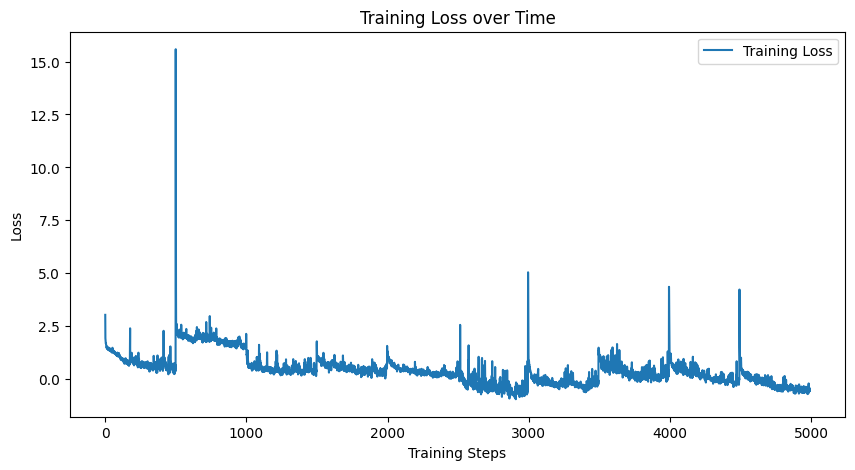

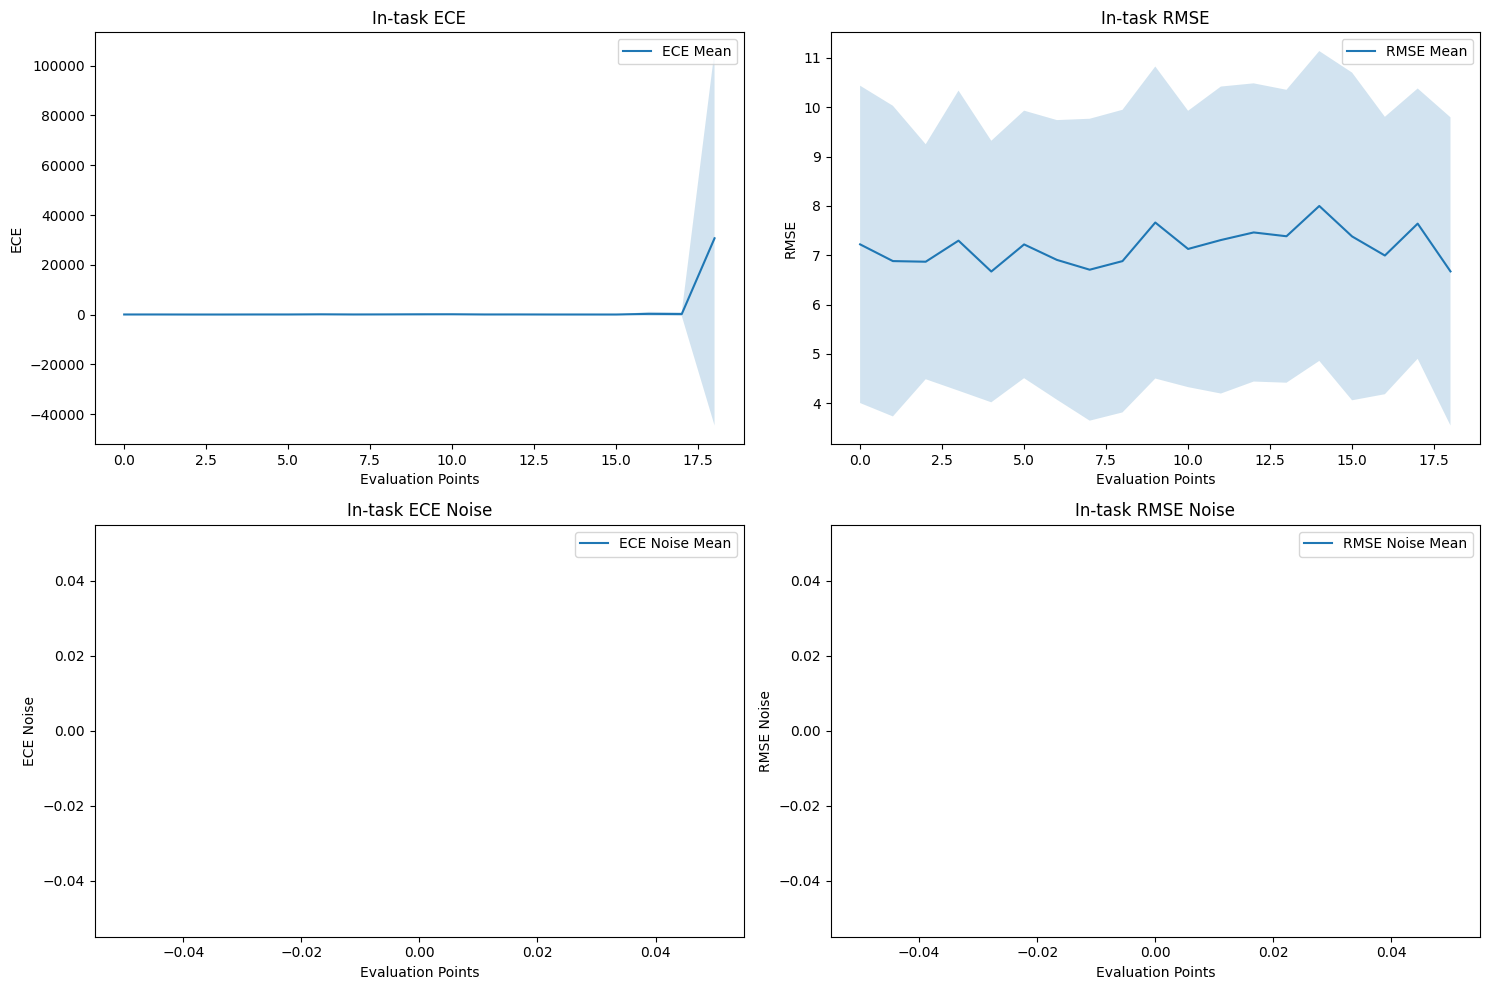

In [34]:
import pickle
import os
import matplotlib.pyplot as plt

# Define the path where the data is saved
save_path = "./noise_0_5_runs/"
model_name = "baseddd_0_1_"

# Load the saved metrics
with open(os.path.join(save_path, model_name + '_training_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

# Extract the data
losses = metrics["training_loss"]
in_task_errors = metrics["training_intask_errors"]
out_task_errors = metrics["training_outtask_errors"]

# Function to plot the losses
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()
    plt.show()

# Function to plot in-task errors
def plot_in_task_errors(errors):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot([x[0] for x in errors['ece']], label='ECE Mean')
    plt.fill_between(range(len(errors['ece'])), 
                     [x[0] - x[1] for x in errors['ece']], 
                     [x[0] + x[1] for x in errors['ece']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('ECE')
    plt.title('In-task ECE')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot([x[0] for x in errors['rmse']], label='RMSE Mean')
    plt.fill_between(range(len(errors['rmse'])), 
                     [x[0] - x[1] for x in errors['rmse']], 
                     [x[0] + x[1] for x in errors['rmse']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('RMSE')
    plt.title('In-task RMSE')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot([x[0] for x in errors['ece_noise']], label='ECE Noise Mean')
    plt.fill_between(range(len(errors['ece_noise'])), 
                     [x[0] - x[1] for x in errors['ece_noise']], 
                     [x[0] + x[1] for x in errors['ece_noise']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('ECE Noise')
    plt.title('In-task ECE Noise')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot([x[0] for x in errors['rmse_noise']], label='RMSE Noise Mean')
    plt.fill_between(range(len(errors['rmse_noise'])), 
                     [x[0] - x[1] for x in errors['rmse_noise']], 
                     [x[0] + x[1] for x in errors['rmse_noise']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('RMSE Noise')
    plt.title('In-task RMSE Noise')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot out-task errors (if applicable)
def plot_out_task_errors(errors):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot([x[0] for x in errors['ece']], label='ECE Mean')
    plt.fill_between(range(len(errors['ece'])), 
                     [x[0] - x[1] for x in errors['ece']], 
                     [x[0] + x[1] for x in errors['ece']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('ECE')
    plt.title('Out-task ECE')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot([x[0] for x in errors['rmse']], label='RMSE Mean')
    plt.fill_between(range(len(errors['rmse'])), 
                     [x[0] - x[1] for x in errors['rmse']], 
                     [x[0] + x[1] for x in errors['rmse']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('RMSE')
    plt.title('Out-task RMSE')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot([x[0] for x in errors['ece_noise']], label='ECE Noise Mean')
    plt.fill_between(range(len(errors['ece_noise'])), 
                     [x[0] - x[1] for x in errors['ece_noise']], 
                     [x[0] + x[1] for x in errors['ece_noise']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('ECE Noise')
    plt.title('Out-task ECE Noise')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot([x[0] for x in errors['rmse_noise']], label='RMSE Noise Mean')
    plt.fill_between(range(len(errors['rmse_noise'])), 
                     [x[0] - x[1] for x in errors['rmse_noise']], 
                     [x[0] + x[1] for x in errors['rmse_noise']], 
                     alpha=0.2)
    plt.xlabel('Evaluation Points')
    plt.ylabel('RMSE Noise')
    plt.title('Out-task RMSE Noise')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the losses
plot_losses(losses)

# Plot the in-task errors
plot_in_task_errors(in_task_errors)